### Домашнее задание <a class="anchor" id="hw"></a><center>

**1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)**

In [169]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [170]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_features=4, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=4)
classification_data, classification_labels = make_circles(n_samples=50, random_state=5)

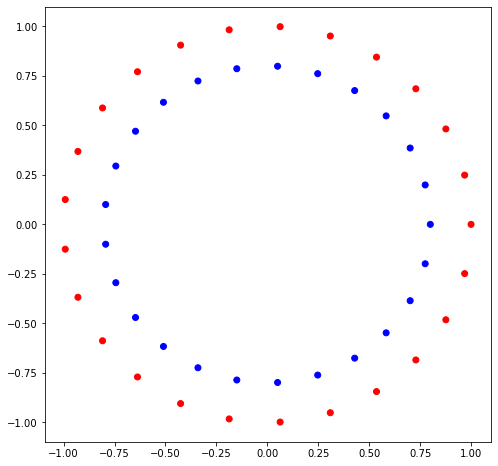

In [171]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [172]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [173]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2} ,$$


In [174]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

$$H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$


In [175]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [176]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [177]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [178]:
import time
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [179]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [180]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [181]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [182]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [183]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0 <= 0.8
--> True:
  Индекс 1 <= -0.8443279255020151
  --> True:
    Прогноз: 0
  --> False:
    Индекс 1 <= 0.7984213827426173
    --> True:
      Индекс 0 <= -0.8090169943749473
      --> True:
        Прогноз: 0
      --> False:
        Индекс 1 <= 0.6754623404016121
        --> True:
          Индекс 1 <= -0.7705132427757894
          --> True:
            Индекс 0 <= -0.6374239897486896
            --> True:
              Прогноз: 0
            --> False:
              Прогноз: 1
          --> False:
            Прогноз: 1
        --> False:
          Индекс 1 <= 0.7705132427757893
          --> True:
            Прогноз: 0
          --> False:
            Прогноз: 1
    --> False:
      Прогноз: 0
--> False:
  Прогноз: 0


In [184]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [185]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)
answers

[1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]

In [186]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [187]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

100.0

In [188]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

73.33333333333333

### ИЗМЕНЕНИЯ

**Глубина дерева**

In [189]:
def build_tree(data, labels, max_depth): 
    gain, t, index = find_best_split(data, labels)

    if gain == 0 or max_depth == 0:
        return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    true_branch = build_tree(true_data, true_labels, max_depth - 1)
    false_branch = build_tree(false_data, false_labels, max_depth - 1)
    return Node(index, t, true_branch, false_branch)

In [190]:
# Построим дерево по обучающей выборке

my_tree = build_tree(train_data, train_labels, max_depth=4)
print_tree(my_tree)

Индекс 0 <= 0.8
--> True:
  Индекс 1 <= -0.8443279255020151
  --> True:
    Прогноз: 0
  --> False:
    Индекс 1 <= 0.7984213827426173
    --> True:
      Индекс 0 <= -0.8090169943749473
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 1
    --> False:
      Прогноз: 0
--> False:
  Прогноз: 0


In [191]:
answers = predict(test_data, my_tree)
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

86.66666666666667

### ИЗМЕНЕНИЯ

**2. *Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.**

In [252]:
# сгенерируем данные
data, targets = make_regression(n_features=2, n_informative=2, random_state=5)

In [253]:
# Разобьем выборку на обучающую и тестовую
train_data_regr, test_data_regr, train_target_regr, test_target_regr = train_test_split(data, 
                                                                                        targets, 
                                                                                        test_size=0.3,
                                                                                        random_state=1)

In [254]:
# И класс терминального узла (листа)
class Leaf:    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
    def predict(self):
        return self.targets.mean()

In [255]:
def mse(targets):
    return np.mean((targets - targets.mean())**2)

In [256]:
# Нахождение наилучшего разбиения

def find_best_split(data, targets):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 4

    root_mse = mse(targets)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_targets, false_targets = split(data, targets, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_targets, false_targets, root_mse)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [257]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, target):

    gain, t, index = find_best_split(data, target)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, target)

    true_data, false_data, true_target, false_target = split(data, target, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_target)
    false_branch = build_tree(false_data, false_target)

    node = Node(index, t, true_branch, false_branch)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return node

In [258]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data_regr, train_target_regr)
print_tree(my_tree)

Индекс 0 <= -1.167278449710173
--> True:
  Прогноз: -121.39064849773837
--> False:
  Индекс 0 <= -0.8139120077465551
  --> True:
    Прогноз: -58.72073718195808
  --> False:
    Индекс 0 <= -0.24341970124625367
    --> True:
      Индекс 0 <= -0.689565232048181
      --> True:
        Прогноз: -65.9463328256142
      --> False:
        Индекс 0 <= -0.5017555471945
        --> True:
          Прогноз: -37.57645681930746
        --> False:
          Прогноз: -20.57908580411487
    --> False:
      Индекс 0 <= -0.10593044205742323
      --> True:
        Прогноз: -17.262696152828372
      --> False:
        Индекс 0 <= 0.012758316706164157
        --> True:
          Прогноз: 10.140019568773557
        --> False:
          Индекс 0 <= 0.2212541228509997
          --> True:
            Прогноз: 25.674141477308968
          --> False:
            Индекс 0 <= 0.3554384723493521
            --> True:
              Прогноз: 22.01482762272139
            --> False:
              Индекс 0 <= 0.4

In [259]:
train_answers = predict(train_data_regr, my_tree)
train_r2 = r2_score(train_target_regr, train_answers)
train_r2

0.9153983061193208

In [260]:
answers = predict(test_data_regr, my_tree)
test_r2 = r2_score(test_target_regr, answers)
test_r2

0.8233170909322728

## Вопрос: 
почему при увеличении значений n_features=10, n_informative=10, метрика R2 становилась очень низкой, иногда даже уходила в минус?